In [470]:
import numpy as np
import pandas as pd
import requests
from lxml import html
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt

In [608]:
def get_web_content(addr, ret = 'html'):
    try:
        pageContent = requests.get(addr) 
    except:
        print('Webpage inaccessible, please correct webpage address')
        
    if ret == 'html':
        return html.fromstring(pageContent.content)
    elif ret == 'soup':
        return BeautifulSoup(pageContent.text, 'html.parser')
    else:
        print('Error: ret tag is invalid in get_web_content')
        return None

        
def get_table_row(tree, xpath, counter):
    try:
        return tree.xpath(xpath.format(counter))
    except:
        print('Cannot extract table rows, check Xpath path and/or row index where content starts (int(counter))')
    

def get_cleaned_row(html_text):
    
    cleaned_html_text=[]
    
    for i in range(len(html_text)-1):
        if html_text[i] != '\n' and html_text[i+1] != '\n':
            j = 1
            while html_text[i+j] != '\n':
                html_text[i] = html_text[i] + html_text[i+j]
                html_text[i+j] = '\n'
                j += 1

    for elem in html_text:
        if elem != '\n':
            cleaned_html_text.append(elem.replace('\n',''))
    
    return cleaned_html_text[0:7]
    

def get_wiki_table(addr, xpath, counter, assembled_list = None):

    tree = get_web_content(addr,'html')
    html_text = get_table_row(tree, xpath, counter)
    
    if not assembled_list:
        assembled_list = []
    
    while html_text:
        assembled_list.append(get_cleaned_row(html_text))
        counter += 1
        html_text = get_table_row(tree, xpath, counter)
        
    return assembled_list  

In [506]:
xpath_0_m = '/html/body/div[3]/div[3]/div[4]/div/table[2]//tr[{}]//text()'
html_add_0_m = 'https://en.wikipedia.org/wiki/List_of_PlayStation_4_games'

full_list = get_wiki_table(html_add_0_m, xpath_0_m, 3)

xpath_m_z = '/html/body/div[3]/div[3]/div[4]/div/table/tbody/tr[{}]//text()'
html_add_m_z = 'https://en.wikipedia.org/wiki/List_of_PlayStation_4_games_(M-Z)'

full_list = get_wiki_table(html_add_m_z, xpath_m_z, 3, full_list)

try:
    ps4_game_list = pd.DataFrame(full_list,columns=['Titles','Genres','Developers','Publishers','ReleaseDate_JP','ReleaseDate_EU','ReleaseDate_NA'] )
except:
    print('Error: issues with converting scraped wiki table data into DataFrame.')
    
release_list = ['ReleaseDate_JP','ReleaseDate_EU','ReleaseDate_NA']

for col in release_list:
    try:
        game_list[col]=pd.to_datetime(game_list[col],infer_datetime_format=True,errors='coerce')
    except:
        print('Could not convert scraped release date columns into datetime format.')

ps4_game_list.head(5)

,Titles,Genres,Developers,Publishers,ReleaseDate_JP,ReleaseDate_EU,ReleaseDate_NA
0,#killallzombies,Shooter,Beatshapers,Beatshapers,Unreleased,"Nov 12, 2014","Oct 28, 2014"
1,10 Second Ninja X,Platform,Four Circle Interactive,Curve Digital,Unreleased,"Jul 19, 2016","Jul 19, 2016"
2,100ft Robot Golf,Sports,No Goblin,No Goblin,Unreleased,"Oct 10, 2016","Oct 10, 2016"
3,101 Ways to Die,"Platform, puzzle",Four Door Lemon,Vision Games,Unreleased,"Mar 22, 2016","Mar 22, 2016"
4,11-11: Memories Retold,Adventure,AardmanDigixArt,Bandai Namco Entertainment,"Nov 9, 2018","Nov 9, 2018","Nov 9, 2018"


In [609]:
def find_pricing_script(script_tag):
    find = False
    counter = -1
    while not find:
        counter += 1
        try:
            script_text = script_tag[counter].text
        except:
            print('Could not find script with the price history, check web address.')
            
        if 'Price, USD' in script_text:
            find = True
            
    return script_text

def find_reg(reg_str,content):
    reg_find = re.findall(reg_str,content)
    assert reg_find is not None, "Could not extract any content, check regex string"
    return reg_find

def convert_date_to_cumdays(series):
    newseries = series.copy()
    newseries[0] = 0
    newseries.iloc[1:] = series.diff().iloc[1:].cumsum().dt.days
    return newseries.astype(float)

def convert_normlogprice(series):
    return np.log(series.div(series[0]))
    
def convert_price_todataframe(reg_output):
    try:
        price_history = pd.DataFrame(reg_output, columns = ['Date','Price'])
    except:
        print('Could not convert scraped price history to dataframe. Check regex function.')
    try:
        price_history['Date'] = pd.to_datetime(price_history['Date'],infer_datetime_format=True,errors='coerce')
    except:
        print('Could not convert scraped price history dates into datetime format')
    try:
        price_history['Price'] = pd.to_numeric(price_history['Price'],errors='coerce')
    except:
        print('Could not convert scraped prices into float format.')
    
    price_history['NormLogPrice'] = convert_normlogprice(price_history['Price'])
    price_history['Days'] = convert_date_to_cumdays(price_history['Date'])
    return price_history


def get_price_history_psprices(addr, reg_string = r'\"x\"\:\s\"(\d{4}-\d{2}-\d{2})\"\,\s\"y\"\:\s(\d+\.\d+)'):
    
    soup = get_web_content(addr,'soup')
    script_text = find_pricing_script(soup.find_all('script'))
    script_text_cut = script_text[0:script_text.find('PS+')]
    reg_output = find_reg(reg_string, script_text_cut)
    
    return convert_price_todataframe(reg_output)


def price_pointplot(df, title, x_col = 'Days',y_col = 'Price'):
    sns.set(color_codes=True, rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    lm = sns.pointplot(x=x_col, y=y_col, data = df, height=6.27, aspect=11.7/8.27)
    lm.axes.set_ylim(0,65)
    plt.setp(lm.get_xticklabels(), rotation=90)
    plt.title(title)

def logprice_regplot(df, title, x_col = 'Days', y_col = 'NormLogPrice', ylim=(0,1.5), days = None):
    sns.set(color_codes=True, rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    if days is not None:
        df = df[df['Days']<=days]
    lm = sns.lmplot(x=x_col, y=y_col, data = df,height=6.27, aspect=11.7/8.27)
    if days is not None:
        lm.axes[0,0].set_xlim(0,days)
    lm.axes[0,0].set_ylim(ylim)
    plt.title(title)

,Date,Price,NormLogPrice,Days
0,2014-10-07,59.99,0.000000,0.0
1,2015-09-16,47.99,-0.223185,344.0
2,2015-09-23,59.99,0.000000,351.0
3,2015-10-14,40.19,-0.400560,372.0
4,2015-10-21,59.99,0.000000,379.0
5,2015-11-27,35.99,-0.510937,416.0
6,2015-12-02,59.99,0.000000,421.0
7,2015-12-08,40.19,-0.400560,427.0
8,2015-12-15,59.99,0.000000,434.0
9,2015-12-25,35.99,-0.510937,444.0


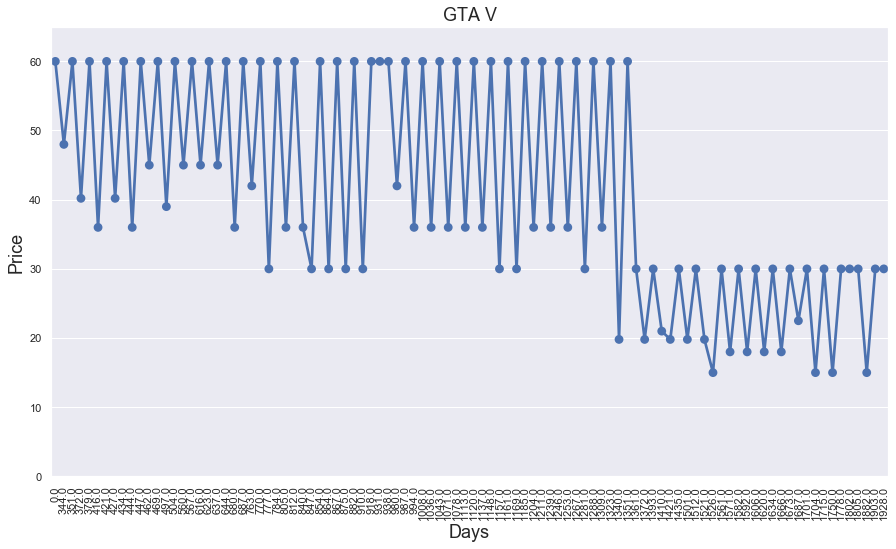

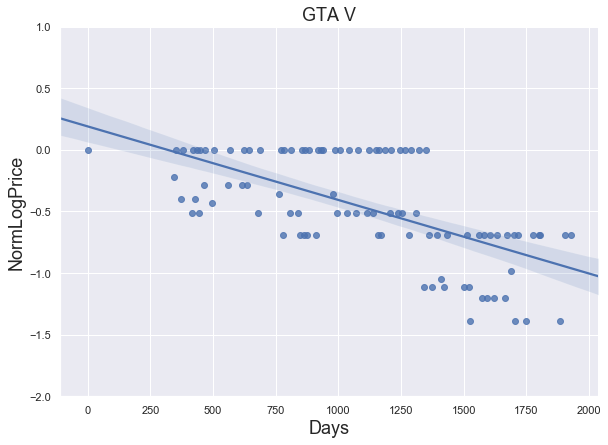

In [559]:
gta_price = get_price_history_psprices('https://psprices.com/region-us/game/13504/grand-theft-auto-v')
price_pointplot(gta_price, 'GTA V')
logprice_regplot(gta_price, 'GTA V',ylim=(-2,1))

gta_price.head(10)

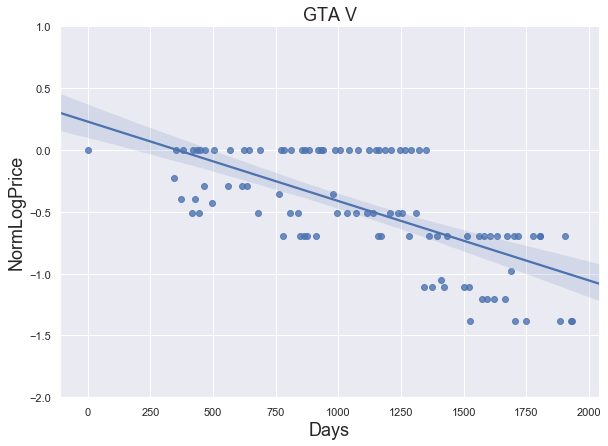

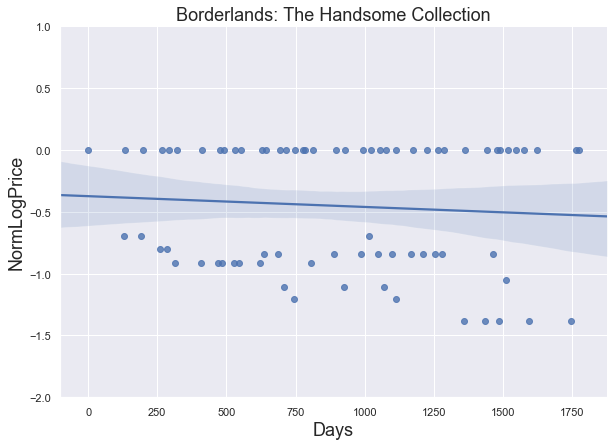

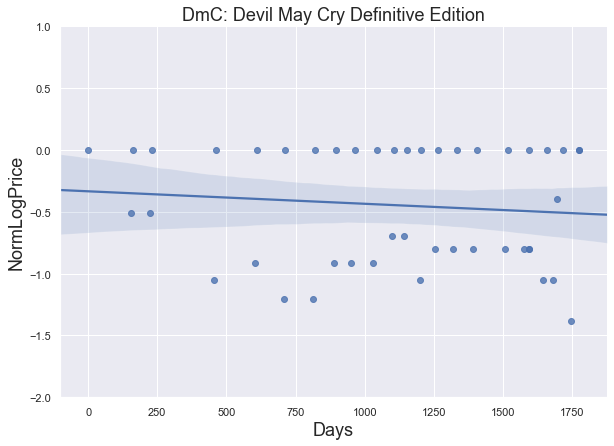

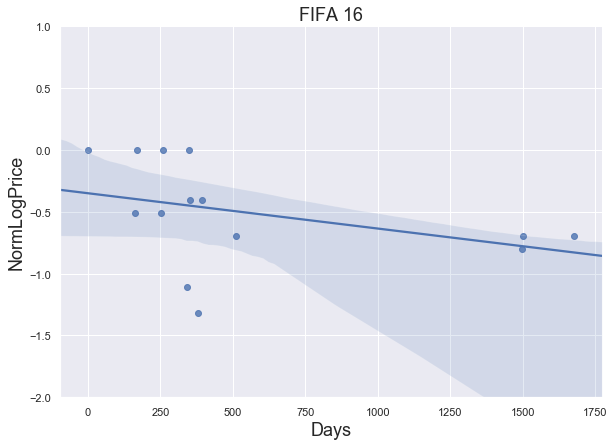

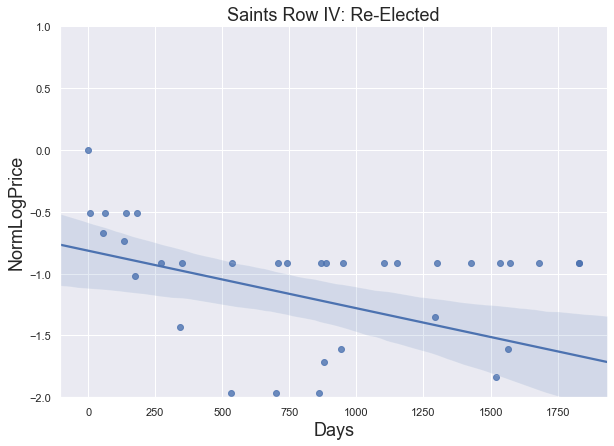

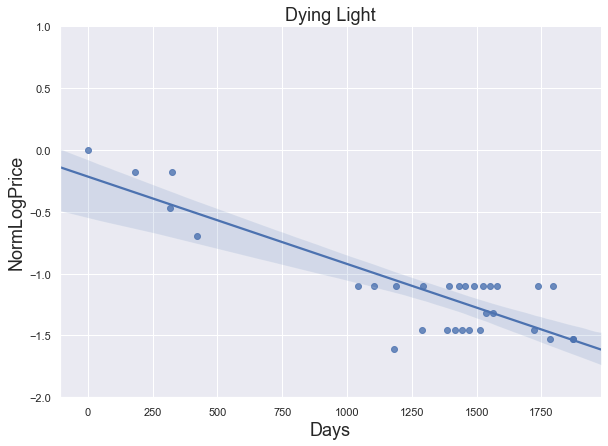

In [612]:
url = 'https://psprices.com/region-us/game/13504/grand-theft-auto-v'
game = 'GTA V'
logprice_regplot(get_price_history_psprices(url), game, ylim=(-2,1),days = None)

url = 'https://psprices.com/region-us/game/94686/borderlands-the-handsome-collection'
game = 'Borderlands: The Handsome Collection'
logprice_regplot(get_price_history_psprices(url), game, ylim=(-2,1),days = None)

url = 'https://psprices.com/region-us/game/94695/dmc-devil-may-cry-definitive-edition'
game = 'DmC: Devil May Cry Definitive Edition'
logprice_regplot(get_price_history_psprices(url), game, ylim=(-2,1),days = None)


url = 'https://psprices.com/region-us/game/100840/ea-sports-fifa-16'
game = 'FIFA 16'
logprice_regplot(get_price_history_psprices(url), game, ylim=(-2,1),days = None)


url = 'https://psprices.com/region-us/game/86510/saints-row-iv-re-elected'
game = 'Saints Row IV: Re-Elected'
logprice_regplot(get_price_history_psprices(url), game, ylim=(-2,1),days = None)


url = 'https://psprices.com/region-us/game/81876/dying-light'
game = "Dying Light"
logprice_regplot(get_price_history_psprices(url), game, ylim=(-2,1),days = None)

